# Potato Disease Classification


In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS = 3 #rgb channel
EPOCHS = 50

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
"PlantVillage",
shuffle=True,
image_size=(IMAGE_SIZE,IMAGE_SIZE),
batch_size=BATCH_SIZE
)
#Loads all images and divides them into 32 batches internally

Found 2152 files belonging to 3 classes.


In [4]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
dataset.take(1) #returns batch of 32 data

<TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [6]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[1 1 2 0 2 1 0 0 1 1 1 1 0 0 0 1 0 0 1 0 0 0 0 0 1 1 1 1 1 2 1 0]


Here, in the above code it return (32, 256, 256, 3) which represents 32 batch size of data, 256/256 image size, 3 is the no. of channels, here it is 3 means, rgb channel.
In second line, data is printed, 32 in no., that is one batch of data, represented as, 0,1,2 which is the class of the data which maybe: early blight, late blight and healthy.

(32, 256, 256, 3)
[0 1 1 0 1 0 1 0 0 0 0 0 0 2 0 1 1 2 1 0 0 0 1 0 1 0 1 0 0 0 1 0]


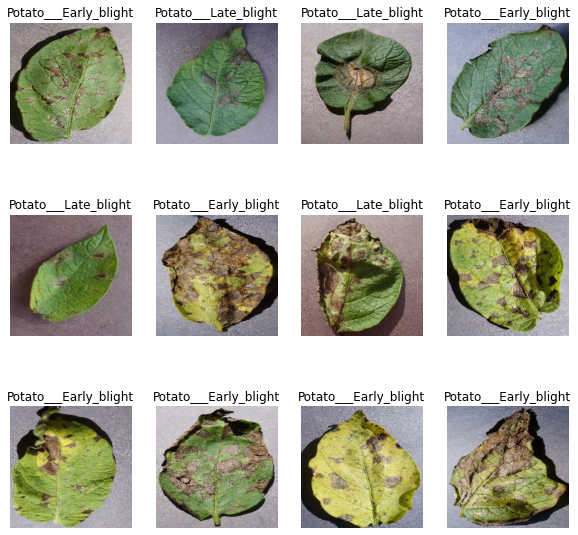

In [7]:
plt.figure(figsize=(10,10)) #size of image
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())
    for i in range(12): #will print 12 images
        ax = plt.subplot(3,4,i+1) #will print in 3*4 matrix format
        plt.imshow(image_batch[i].numpy().astype("uint8")) #converting the tensor object into numpy and then unto int8
        plt.title(class_names[labels_batch[i]])
        plt.axis("off") #eliminates the axis around, so only image is displayed

Dividing dataset into training data,testing data and validation data

Training Data: 80%
Validation Data: 10%
Testing Data: 10%

Testing data: Final model's accuracy check
Validation data: During training, each epoch, to test accuracy of each epoch

In [8]:
#Function to split the dataset into training, testing and validation data
def get_partitions(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split+val_split+test_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
        
    train_size = int(train_split*ds_size)
    val_size = int(val_split*ds_size)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [9]:
train_ds, val_ds, test_ds = get_partitions(dataset) #extracting all three datasets by splitting

In [10]:
len(train_ds) #length of training dataset

54

In [11]:
len(test_ds) #Length of testing dataset

8

In [12]:
len(val_ds) #Length of validation dataset

6

cache: when training occurs, it stores the images into memory and loading images from disk's time is saved, speed increases of training comparatively
shuffle: shuffling images so that after randomizing performance becomes better of the model
prefetch: Performance tuning

In [13]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [14]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch[0].numpy()/255) #Firstly the images are in 3-Dimensional mode with value within 0-255, we first normalize it by dividing by 255
    

[[[0.627451   0.5764706  0.6117647 ]
  [0.63529414 0.58431375 0.61960787]
  [0.5764706  0.5254902  0.56078434]
  ...
  [0.75686276 0.7137255  0.74509805]
  [0.7647059  0.72156864 0.7529412 ]
  [0.77254903 0.7294118  0.7607843 ]]

 [[0.64705884 0.59607846 0.6313726 ]
  [0.61960787 0.5686275  0.6039216 ]
  [0.6509804  0.6        0.63529414]
  ...
  [0.7019608  0.65882355 0.6901961 ]
  [0.7176471  0.6745098  0.7058824 ]
  [0.7294118  0.6862745  0.7176471 ]]

 [[0.6392157  0.5882353  0.62352943]
  [0.58431375 0.53333336 0.5686275 ]
  [0.6901961  0.6392157  0.6745098 ]
  ...
  [0.73333335 0.6901961  0.72156864]
  [0.75686276 0.7137255  0.74509805]
  [0.78039217 0.7372549  0.76862746]]

 ...

 [[0.6784314  0.59607846 0.62352943]
  [0.5764706  0.49411765 0.52156866]
  [0.60784316 0.5254902  0.5529412 ]
  ...
  [0.7647059  0.6901961  0.7137255 ]
  [0.6862745  0.6117647  0.63529414]
  [0.62352943 0.54901963 0.57254905]]

 [[0.58431375 0.5019608  0.5294118 ]
  [0.654902   0.57254905 0.6       ]


In [15]:
#Creating layers in keras for scaling data
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [16]:
#Data Augmentation Layer for flipping and rotation
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])


In [17]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, kernel_size=(3,3), activation='relu',input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])
model.build(input_shape=input_shape)

In [18]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                  

In [19]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [20]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS
)

Epoch 1/50
54/54 [==============================] - 97s 2s/step - loss: 0.9161 - accuracy: 0.4664 - val_loss: 0.8581 - val_accuracy: 0.4896
Epoch 2/50
54/54 [==============================] - 67s 1s/step - loss: 0.7455 - accuracy: 0.5897 - val_loss: 0.7406 - val_accuracy: 0.6250
Epoch 3/50
54/54 [==============================] - 66s 1s/step - loss: 0.5454 - accuracy: 0.7581 - val_loss: 0.4253 - val_accuracy: 0.8333
Epoch 4/50
54/54 [==============================] - 65s 1s/step - loss: 0.4398 - accuracy: 0.8142 - val_loss: 0.7733 - val_accuracy: 0.5990
Epoch 5/50
54/54 [==============================] - 66s 1s/step - loss: 0.3246 - accuracy: 0.8681 - val_loss: 0.2886 - val_accuracy: 0.9115
Epoch 6/50
54/54 [==============================] - 65s 1s/step - loss: 0.2634 - accuracy: 0.8999 - val_loss: 0.2823 - val_accuracy: 0.9062
Epoch 7/50
54/54 [==============================] - 67s 1s/step - loss: 0.1553 - accuracy: 0.9439 - val_loss: 0.7424 - val_accuracy: 0.8125
Epoch 8/50
54/54 [==

Epoch 42/50
54/54 [==============================] - 65s 1s/step - loss: 0.0071 - accuracy: 0.9977 - val_loss: 0.0163 - val_accuracy: 0.9896
Epoch 43/50
54/54 [==============================] - 64s 1s/step - loss: 0.0243 - accuracy: 0.9931 - val_loss: 0.1251 - val_accuracy: 0.9635
Epoch 44/50
54/54 [==============================] - 137s 3s/step - loss: 0.0505 - accuracy: 0.9838 - val_loss: 0.4162 - val_accuracy: 0.9219
Epoch 45/50
54/54 [==============================] - 64s 1s/step - loss: 0.0324 - accuracy: 0.9907 - val_loss: 0.0267 - val_accuracy: 0.9948
Epoch 46/50
54/54 [==============================] - 126s 2s/step - loss: 0.0510 - accuracy: 0.9861 - val_loss: 0.0689 - val_accuracy: 0.9792
Epoch 47/50
54/54 [==============================] - 110s 2s/step - loss: 0.0122 - accuracy: 0.9965 - val_loss: 0.0757 - val_accuracy: 0.9844
Epoch 48/50
54/54 [==============================] - 69s 1s/step - loss: 0.0237 - accuracy: 0.9896 - val_loss: 0.1202 - val_accuracy: 0.9531
Epoch 49/5

In [21]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 5s 247ms/step - loss: 0.0322 - accuracy: 0.9922


In [22]:
scores

[0.032198403030633926, 0.9921875]

In [23]:
history

In [24]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [25]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [27]:
len(history.history['loss'])

50

In [28]:
history.history['accuracy']

[0.46643519401550293,
 0.5896990895271301,
 0.7581018805503845,
 0.8142361044883728,
 0.8680555820465088,
 0.8998842835426331,
 0.9438657164573669,
 0.9091435074806213,
 0.9612268805503845,
 0.9774305820465088,
 0.9618055820465088,
 0.9716435074806213,
 0.9641203880310059,
 0.9832175970077515,
 0.9809027910232544,
 0.984375,
 0.9768518805503845,
 0.9756944179534912,
 0.9728009104728699,
 0.9884259104728699,
 0.9768518805503845,
 0.9884259104728699,
 0.9774305820465088,
 0.9866898059844971,
 0.9837962985038757,
 0.9878472089767456,
 0.9959490895271301,
 0.9924768805503845,
 0.9866898059844971,
 0.9936342835426331,
 0.9866898059844971,
 0.984375,
 0.9971064925193787,
 0.9936342835426331,
 0.9988425970077515,
 0.9953703880310059,
 0.9959490895271301,
 0.9942129850387573,
 0.9907407164573669,
 0.9918981194496155,
 0.9832175970077515,
 0.9976851940155029,
 0.9930555820465088,
 0.9837962985038757,
 0.9907407164573669,
 0.9861111044883728,
 0.9965277910232544,
 0.9895833134651184,
 0.98900461

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

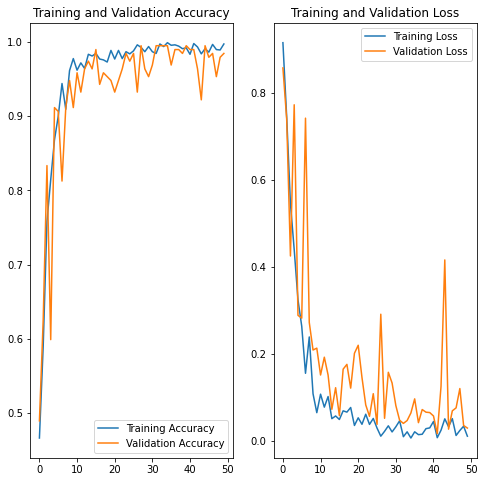

In [30]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

First image to predict
Actual Label: Potato___Early_blight
1/1 [==============================] - 0s 314ms/step
Predicted Label: Potato___Early_blight


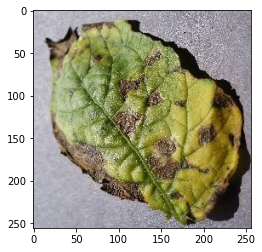

In [38]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    first_image = images_batch[0].numpy().astype("uint8")
    
    print("First image to predict")
    plt.imshow(first_image)
    print("Actual Label:",class_names[labels_batch[0].numpy()])
    
    batch_prediction = model.predict(images_batch)
    print("Predicted Label:",class_names[np.argmax(batch_prediction[0])])

In [39]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) #create a batch
    
    predictions = model.predict(img_array)
    
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 100ms/step


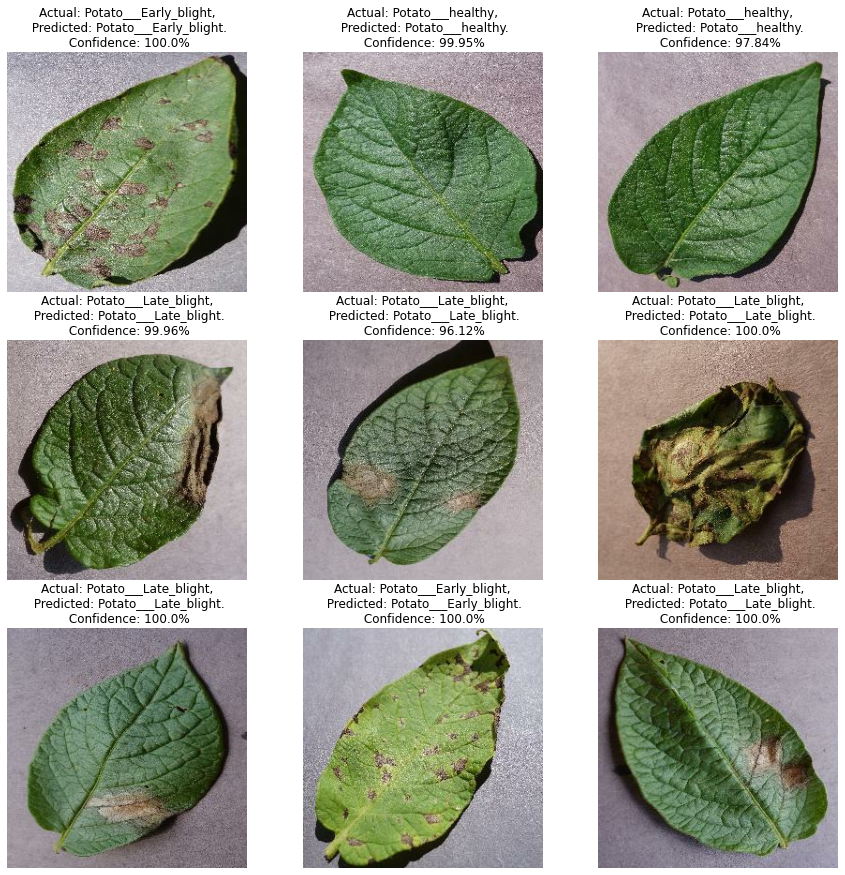

In [43]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence = predict(model, images[i].numpy())
        
        actual_class = class_names[labels[i]]
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        plt.axis("off")

In [44]:
model_version = 1
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/1\assets


INFO:tensorflow:Assets written to: ../models/1\assets
